1) parameters tune

2) learning curve

3) является ли предыдущая строка продолжением следующей - сделать лучше + тесты

4) попробовать несколько разных классификаторов и сделать график получившихся усредненных скоров 

5) разбить на модули

In [1]:
import re
import cv2
import json
import numpy as np
from functools import reduce
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import xgbfir
from itertools import product
from sklearn.utils import shuffle

In [2]:
reg_expr = [re.compile(r'\d+(\.\d+)+\D'), # 1.1.1 1
            re.compile(r'\d+[\)\}]'), # 1) 2
            re.compile(r'\w+(\.\w+)+\W'), # 3
            re.compile(r'[а-яА-Я\d]+(\.[а-яА-Я\d]+)+\W'), # b.b.b 4
            re.compile(r'[\wа-яА-Я]\.\W'), # b. 5
            re.compile(r'[6а-яА-Яa-zA-Z][\)\}]'), # б) 6
            re.compile(r'\-|—'), # - 7
            re.compile(r'®|\*'), # * 8
            re.compile(r'[a-zа-я]'), # строчная буква в начале 9
            re.compile(r'[A-ZА-Я]'),  # заглавная буква в начале 10
            re.compile(r'Раздел|Подраздел|Глава|Параграф|Секция|Часть|Статья'), # 11 
            re.compile(r'[\wа-я] ')] # 12

def add_reg_features(line):
    features = [0] * len(reg_expr)
    i = 0
    for expr in reg_expr:
        match = expr.search(line)
    
        if match:
            if match.start() == 0:
                features[i] = 1
        i += 1
        
    return features

In [3]:
end_reg_expr = [re.compile(r'.*\.'),
                re.compile(r'.*;'),
                re.compile(r'.*:'),
                re.compile(r'.*,'),
                re.compile(r'.*[\wа-яА-Я]'),
                re.compile(r'[А-ЯA-Z\.,\s]+')] # uppercase

def add_end_reg_features(line):
    features = [0] * len(end_reg_expr)
    i = 0
    for expr in end_reg_expr:
        match = expr.fullmatch(line)
        if match:
            features[i] = 1
        i += 1
    return features

In [4]:
# 1.1.1 -> 1.1.2
# 1) -> 2)
# 1. -> 2.
# -

# unit tests!!!
# analyzing previous lines

RE_LIST1 = re.compile(r'\d+(\.\d+)+\D') # 1.1.1
RE_LIST2 = re.compile(r'\d+[\)\.]\s') # 1) 1.
RE_LIST3 = re.compile(r'\-|—') # -
RE_LIST4 = re.compile(r'[a-zA-Zа-яА-Я][\)\.]\s') # a)

def list_continue(doc_info, line, line_num):
    match = RE_LIST1.match(line)
    if match:
        last_num = int(match.group()[-2])
        for i in range(line_num - 1, -1, -1):
            doc_line = doc_info[i]['text']
            match = RE_LIST1.match(doc_line)
            if match:
                return last_num == int(match.group()[-2]) + 1
        return False
    match = RE_LIST2.match(line)
    if match:
        last_num = int(match.group()[:-2])
        for i in range(line_num - 1, -1, -1):
            doc_line = doc_info[i]['text']
            match = RE_LIST2.match(doc_line)
            if match:
                return last_num == int(match.group()[:-2]) + 1
        return False
    match = RE_LIST3.match(line)
    if match:
        for i in range(line_num - 1, -1, -1):
            doc_line = doc_info[i]['text']
            match = RE_LIST3.match(doc_line)
            if match:
                return True
        return False
    match = RE_LIST4.match(line)
    if match:
        last_num = ord(match.group()[-2])
        for i in range(line_num - 1, -1, -1):
            doc_line = doc_info[i]['text']
            match = RE_LIST1.match(doc_line)
            if match:
                return last_num == ord(match.group()[-2]) + 1
        return False
    return False

In [5]:
# font-weight detection

def bold_mean_color(bbox, img, d_ksize, e_ksize):
    x, y, w, h = bbox
    crop_img = img[y:y + h, x:x + w]
    kernel = np.ones((d_ksize, d_ksize),np.uint8)
    dilation = cv2.dilate(crop_img, kernel, iterations = 1)
    kernel = np.ones((e_ksize, e_ksize),np.uint8)
    erosion = cv2.erode(dilation, kernel, iterations = 1)
    avg_color_per_row = np.average(erosion, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)
    return np.average(avg_color)

In [6]:
# amount letters of the first word in line

RE_WORD = re.compile(r'[a-zA-Zа-яА-Я]+')
RE_FIRST = re.compile(r'\S+\s')

def letters_cnt(line):
    res = [0, 0, 0]
    match = RE_WORD.search(line)
    if match:
        if match.start() == 0: # word in the beginning of the line
            res[0] = len(match.group(0))
    match = RE_FIRST.search(line)
    if match:
        if match.start() == 0: # some characters in the beginning of the line
            res[1] = len(match.group(0))
    words = line.split()
    if len(words) >= 2:
        res[2] = len(words[1])
    return res

In [7]:
def add_bold_mean_colors(bbox, img, num):
    res = []
    for i in range(2, num + 1):
        res.append(bold_mean_color(bbox, img, i, i ))
    return res

In [9]:
class AddImgFeatures:
    def __init__(self):
        pass
    
    def fit(self):
        pass
    
    def transform(self, X):
        """
        X - [{"name": "doc_name", "entities": [{"text": "", "bbox": []}]}]
        returns features
        """
        features = []
        for doc in X:
            doc_features = []
            doc_name = doc['name']
            doc_info = doc['entities']
            num_bold = 7
            img = cv2.imread('docs/' + doc_name)
            heigth = img.shape[0]
            width = img.shape[1]
            i = 0
            for line_info in doc_info:
                #list_cont = list_continue(doc_info, line_info['text'], i) # several different features???
                word_cnt = len(line_info['text'].split())
                line_length = len(line_info['text'])
                
                line_features = [line_info['bbox'][0] / width, # left
                                 line_info['bbox'][1] / heigth, # top
                                 line_info['bbox'][3] / heigth] # height
                                 #line_length, word_cnt, list_cont] 
                line_features += add_bold_mean_colors(line_info['bbox'], img, num_bold)
                line_features += letters_cnt(line_info['text'])
                line_features += add_reg_features(line_info['text'])
                #line_features += add_end_reg_features(line_info['text'])
                doc_features.append(line_features)
                i += 1
            features.append(doc_features)
        return features
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [10]:
def add_prev_next_features(doc, line_features, num_line):
    """
    doc - list of line_features
    line_features - list of features
    """
    add_f = [0] * len(line_features)
    extended_doc = [add_f] * 4 + doc + [add_f] * 4
    prev_features = reduce(lambda x, y: x + y, 
                           extended_doc[num_line: num_line + 4])
    next_features = reduce(lambda x, y: x + y, 
                           extended_doc[num_line + 5: num_line + 9])
    return line_features + prev_features + next_features

In [11]:
class AddPrevNextFeatures:
    def __init__(self):
        pass
    
    def fit(self):
        pass
    
    def transform(self, X):
        """
        X - list of doc_features
        doc_features - list of line_features
        
        for each line 4 previous and 4 next features added
        result list of lines features
        """
        result = []
        for doc_features in X:
            i = 0
            l = len(doc_features)
#             mean_left = np.sum(list(map(lambda x: x[0], doc_features))) / l
#             mean_heigth = np.sum(list(map(lambda x: x[2], doc_features))) / l
#             mean_line_length = np.sum(list(map(lambda x: x[3], doc_features))) / l
#             mean_word_cnt = np.sum(list(map(lambda x: x[4], doc_features))) / l
#             mean_bold_color = np.sum(list(map(lambda x: x[9], doc_features))) / l # bold5
#             mean_word_letters_cnt = np.sum(list(map(lambda x: x[12], doc_features))) / l 
            for line_features in doc_features:
#                 new_features = add_prev_next_features(doc_features, line_features, i)
#                 i += 1
#                 new_features += [mean_left, mean_heigth, mean_line_length, 
#                                  mean_word_cnt, mean_bold_color, mean_word_letters_cnt]
#                 result.append(new_features)
                  result.append(line_features)
        return np.array(result)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib.colors import ListedColormap
h = .02  # step size in the mesh

names = ["Nearest Neighbors",
         "Logistic Regression",
         "Gradient Bootsting", "XGBoost"]

classifiers = [
    KNeighborsClassifier(3),
    LogisticRegression(max_iter=10000),
    GradientBoostingClassifier(),
    XGBClassifier()]

In [22]:
label2class = {
    "header" : 1,
    "list" : 2,
    "text" : 3,
    "other" : 4
}

with open("data.json", "r") as read_file:
    docs = json.load(read_file)
    y = []
    for doc in docs:
        elem = [label2class[line['label']] for line in doc['entities']]
        y.append(elem)
    X = []
    for doc in docs:
        elem = {}
        elem['name'] = doc['name']
        elem['entities'] = [{'text': line_info['text'], 
                        'bbox': [line_info['x'], line_info['y'],
                                line_info['width'], line_info['height']]}
                      for line_info in doc['entities']]
        X.append(elem)
    X = np.array(X)
    y = np.array(y)

In [23]:
aif = AddImgFeatures()
X = np.array(aif.transform(X))
X_vect = np.array(reduce(lambda x1, x2: x1 + x2, X))
X_vect[:, 0].min(), X_vect[:, 0].max(), X_vect[:, 6].min(), X_vect[:, 6].max()

(0.02902055622732769, 0.992744860943168, 171.78796272979102, 255.0)

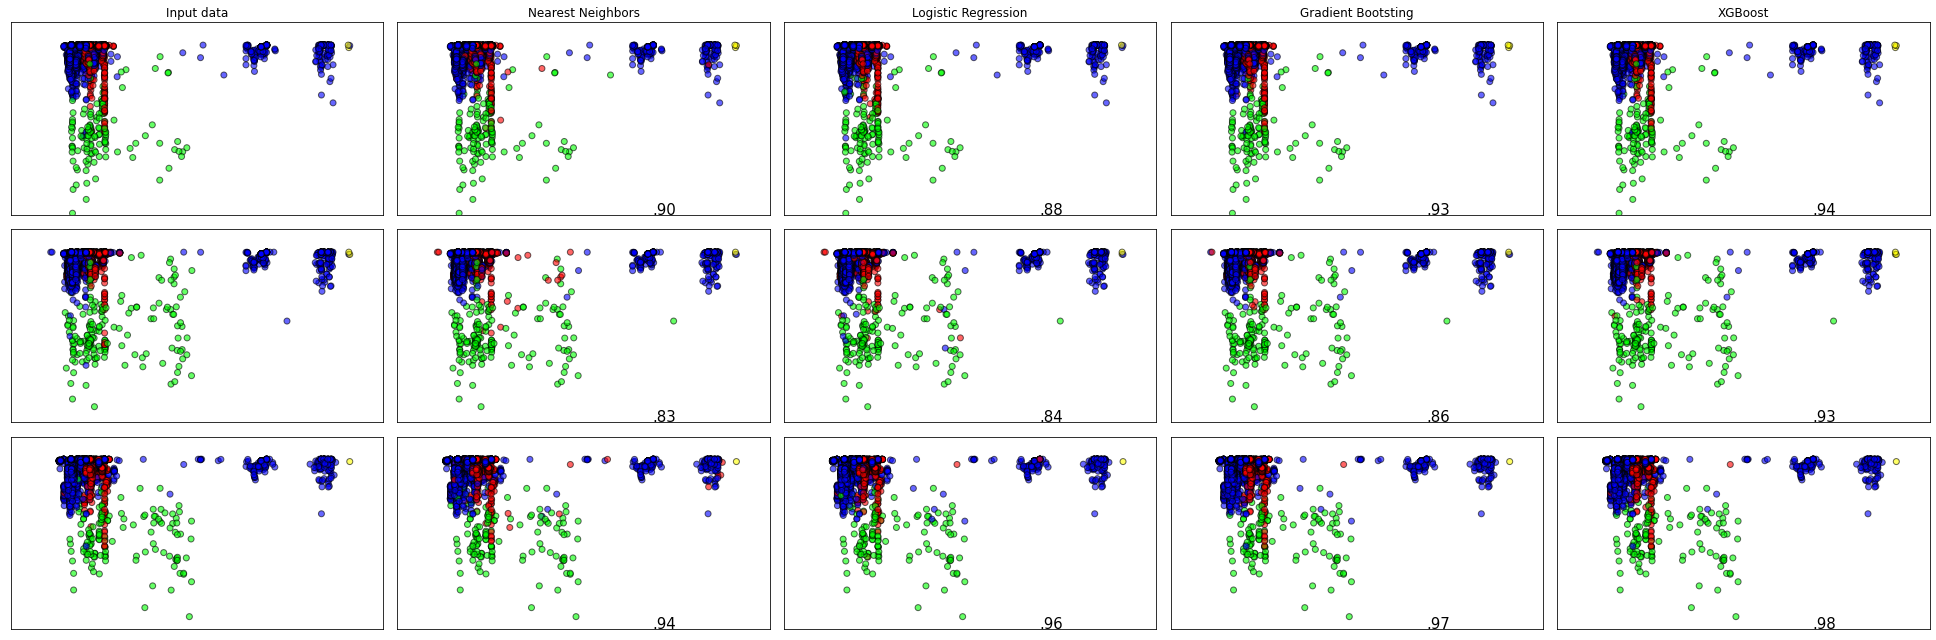

In [37]:
x_min, x_max, y_min, y_max = -0.1, 1.1, 180, 265

figure = plt.figure(figsize=(27, 9))
n_folds = 3
scores = [[] for i in range(len(classifiers))]

i = 1
kf = KFold(n_splits=n_folds)

for train_index, test_index in tqdm(kf.split(X), total=n_folds):
    X_train, X_test = X[train_index], X[test_index]
    y_train = np.array(reduce(lambda x1, x2: x1 + x2, y[train_index]))
    y_test = np.array(reduce(lambda x1, x2: x1 + x2, y[test_index]))
    
    X_train_vect = np.array(reduce(lambda x1, x2: x1 + x2, X_train))
    X_test_vect = np.array(reduce(lambda x1, x2: x1 + x2, X_test))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#00FF00', '#FF0000', '#0000FF', '#FFFF00'])
    ax = plt.subplot(n_folds, len(classifiers) + 1, i)
    if i == 1:
        ax.set_title("Input data")
#     # Plot the training points
#     ax.scatter(X_train_vect[:, 0], X_train_vect[:, 9], c=y_train, cmap=cm_bright,
#                edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test_vect[:, 0], X_test_vect[:, 6], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for j, (name, clf) in tqdm(enumerate(zip(names, classifiers))):
        ax = plt.subplot(n_folds, len(classifiers) + 1, i)
        clf = make_pipeline(AddPrevNextFeatures(), clf)
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = f1_score(y_test, y_pred, average='macro')
        scores[j].append(score)

#         # Plot the training points
#         ax.scatter(X_train_vect[:, 0], X_train_vect[:, 9], c=y_train, cmap=cm_bright,
#                    edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test_vect[:, 0], X_test_vect[:, 6], c=y_pred, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if i == j + 2:
            ax.set_title(name)
        ax.text(x_max - .3, y_min + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.savefig('graphics.png')

In [39]:
scores

[[0.8989185758902782, 0.8326945013402954, 0.9433949803668408],
 [0.878138161158423, 0.844849394729182, 0.9632954316566809],
 [0.9314149107269931, 0.8576175592014441, 0.9721201863498916],
 [0.9379941346298146, 0.932748994318376, 0.9806249287357447]]

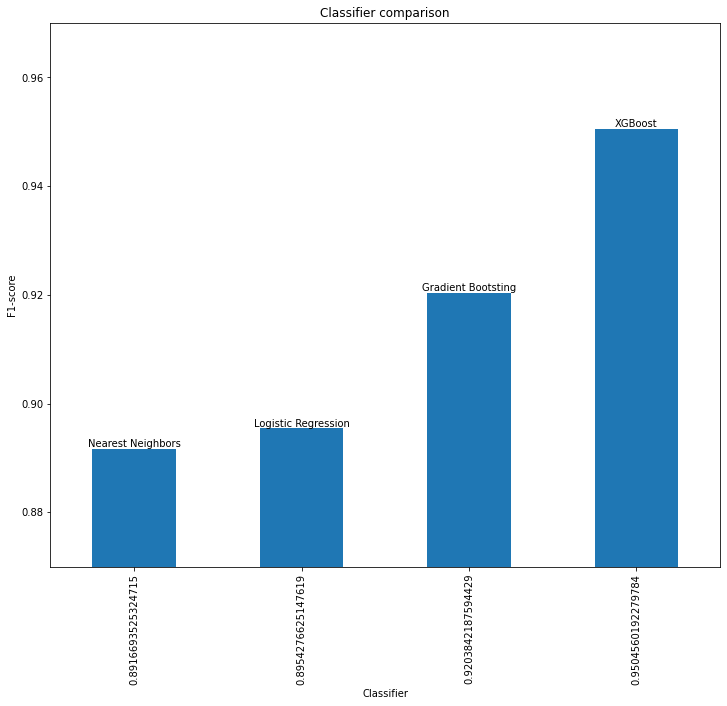

In [43]:
import pandas as pd

scores = [np.mean(score) for score in scores]
scores_series = pd.Series(scores)
# Plot the figure.
plt.figure(figsize=(12, 10))
ax = scores_series.plot(kind='bar', ylim=(0.87, 0.97))
ax.set_title('Classifier comparison')
ax.set_xlabel('Classifier')
ax.set_ylabel('F1-score')
ax.set_xticklabels(scores)

rects = ax.patches

for rect, name in zip(rects, names):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, name,
            ha='center', va='bottom')
plt.savefig('scores.png')

In [ ]:
clf = make_pipeline(AddImgFeatures(),
                    AddPrevNextFeatures(),
                    XGBClassifier())

scores = []

n_folds = 3
kf = KFold(n_splits=n_folds)
for train_index, test_index in tqdm(kf.split(X), total=n_folds):
    X_train, X_test = X[train_index], X[test_index]
    y_train = np.array(reduce(lambda x1, x2: x1 + x2, y[train_index]))
    y_test = np.array(reduce(lambda x1, x2: x1 + x2, y[test_index]))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = f1_score(y_test, y_pred, average='macro')
    print(score)
    scores.append(score)

print(scores)
print(np.mean(scores))

In [ ]:
feature_extractor = make_pipeline(AddImgFeatures(),
                                  AddPrevNextFeatures())
xgb_cmodel = XGBClassifier()

X, y = shuffle(X, y, random_state=1)
X_train, X_test = X[:400], X[400:]
y_train = np.array(reduce(lambda x1, x2: x1 + x2, y[:400]))
y_test = np.array(reduce(lambda x1, x2: x1 + x2, y[400:]))

X_train = feature_extractor.fit_transform(X_train)
X_test = feature_extractor.fit_transform(X_test)

xgb_cmodel.fit(X_train, y_train)

y_pred = xgb_cmodel.predict(X_test)
score = f1_score(y_test, y_pred, average='macro')
score

In [ ]:
def get_feature_names(names):
    feature_names = names.copy()
    for i in range(1, 5):
        for name in names:
            feature_names.append(str(i) + '_prev_' + name)
    for i in range(1, 5):
        for name in names:
            feature_names.append(str(i) + '_next_' + name)
    return feature_names

In [ ]:
feature_names = get_feature_names(['left', 'top', 'height',
                                   'line_length', 'word_cnt', 'list_cont',
                                   'bold2', 'bold3', 'bold4', 'bold5', 'bold6', 'bold7',
                                   'word_letters_cnt', 'first_cnt', 'second_cnt',
                                   'reg1', 'reg2','reg3', 'reg4', 'reg5', 'reg6', 
                                   'reg7', 'reg8', 'reg9', 'reg10', 'reg11', 'reg12',
                                   'end_reg1', 'end_reg2', 'end_reg3', 
                                   'end_reg4', 'end_reg5', 'uppercase'])

feature_names += ['mean_left', 'mean_height', 'mean_line_length', 
                  'mean_word_cnt', 'mean_bold_color', 'mean_word_letters_cnt']

xgbfir.saveXgbFI(xgb_cmodel, feature_names=feature_names, 
                 OutputXlsxFile='fearures_importances.xlsx')

X_test [{"name": "doc_name", "entities": [{"text": "", "bbox": []}]}]

In [ ]:
X_train, X_test = X[:400], X[400:]

d = {}
i = 0
for doc_info in X_test:
    for line_info in doc_info['entities']:
        d[(tuple(line_info['bbox']), doc_info['name'], 
           line_info["text"])] = [y_test[i], y_pred[i]]
        i += 1

In [ ]:
color_dict = {
    1 : (0, 0, 255),
    2 : (0, 255, 0),
    3 : (255, 0, 0),
    4 : (0, 255, 255)
}
class2label = {
    1: "header", 
    2: "list", 
    3: "text", 
    4: "other"
}

grouped_by_dock = defaultdict(list)
for item in d.items():
    key, (real_class, predicted_class) = item
    file_name = key[1]
    grouped_by_dock[file_name].append(item)


for file_name, items in tqdm(grouped_by_dock.items()):
    
    img = None 
    for key, (real_class, predicted_class) in items:        
        if real_class != predicted_class:
            print(key[2])
            print()
            if img is None:
                img = cv2.imread('docs/' + file_name)
            (x, y, w, h) = key[0]
            cv2.rectangle(img, (x, y), (x + w, y + h), color_dict[predicted_class], 2)
            cv2.putText(img, class2label[predicted_class] + 
                        " " + class2label[real_class], 
                        (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, 
                        color_dict[predicted_class], 2)
    if img is not None:
        cv2.imwrite('different_docs/' + file_name, img)        